## Importing Libraries

In [1]:
!pip install pandas spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 871.5 kB/s eta 0:00:15
     --------------------------------------- 0.1/12.8 MB 944.1 kB/s eta 0:00:14
      --------------------------------------- 0.2/12.8 MB 1.1 MB/s eta 0:00:12
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.4/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.6/12.8 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.7/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.8/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.8 MB 1.6 M

In [2]:
import pandas as pd
!pip install scikit-optimize
!pip install imbalanced-learn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# imports
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# increase column width
pd.set_option('display.max_colwidth', 100)

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# dumping models to files
import os
from joblib import dump

## Data Preparation

In [3]:
fb_data = pd.read_excel('Facebook Audience.xlsx')

In [4]:
fb_data.head()

,Age,Gender,Day,Location,Reach,Impressions,Frequency,Currency,Amount spent (GBP),Attribution setting,Link clicks,CPC (all),Reporting starts,Reporting ends
0,18-24,female,2024-04-04,London,1.0,1.0,1,GBP,0.01,7-day click or 1-day view,NaN,NaN,2022-05-13,2024-06-03
1,18-24,male,2024-04-04,London,47.0,48.0,1.021277,GBP,0.2,7-day click or 1-day view,3.0,0.066667,2022-05-13,2024-06-03
2,25-34,female,2024-04-04,London,1.0,1.0,1,GBP,0.07,7-day click or 1-day view,NaN,NaN,2022-05-13,2024-06-03
3,25-34,female,2024-04-04,London,1.0,1.0,1,GBP,0.02,7-day click or 1-day view,NaN,NaN,2022-05-13,2024-06-03
4,25-34,male,2024-04-04,London,23.0,24.0,1.043478,GBP,0.13,7-day click or 1-day view,NaN,0.13,2022-05-13,2024-06-03


In [5]:
fb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Age                  12400 non-null  object        
 1   Gender               12400 non-null  object        
 2   Day                  12400 non-null  datetime64[ns]
 3   Location             12400 non-null  object        
 4   Reach                12380 non-null  float64       
 5   Impressions          12399 non-null  float64       
 6   Frequency            12380 non-null  object        
 7   Currency             12399 non-null  object        
 8   Amount spent (GBP)   11508 non-null  object        
 9   Attribution setting  12399 non-null  object        
 10  Link clicks          5146 non-null   float64       
 11  CPC (all)            6287 non-null   object        
 12  Reporting starts     12400 non-null  datetime64[ns]
 13  Reporting ends       12399 non-

In [6]:
fb_data['Gender'].value_counts()

male       4892
female     4384
unknown    3124
Name: Gender, dtype: int64

In [7]:
fb_data['Age'].value_counts()

35-44    2731
25-34    2713
45-54    2560
18-24    1583
55-64    1442
65+      1361
13-17      10
Name: Age, dtype: int64

In [8]:
fb_data['Location'].value_counts()

London                  8538
East Anglia             2690
Norwich                  368
London & East Anglia     357
Manningtree              252
Greener                  195
Name: Location, dtype: int64

In [9]:
fb_data.describe()

,Reach,Impressions,Link clicks
count,12380.00000,12399.000000,5146.000000
mean,108.49580,112.394064,4.165760
std,241.61555,248.264649,5.203826
min,1.00000,1.000000,1.000000
25%,4.00000,4.000000,1.000000
50%,20.00000,21.000000,2.000000
75%,94.00000,99.000000,5.000000
max,3375.00000,3375.000000,53.000000


## Data Preprocessing

In [10]:
# Convert appropriate columns to numeric
fb_data['Amount spent (GBP)'] = fb_data['Amount spent (GBP)'].replace('GBP', np.nan)
fb_data['Amount spent (GBP)'] = pd.to_numeric(fb_data['Amount spent (GBP)'], errors='coerce')
fb_data['Reach'] = pd.to_numeric(fb_data['Reach'], errors='coerce')
fb_data['Impressions'] = pd.to_numeric(fb_data['Impressions'], errors='coerce')
fb_data['Frequency'] = pd.to_numeric(fb_data['Frequency'], errors='coerce')
fb_data['Link clicks'] = pd.to_numeric(fb_data['Link clicks'], errors='coerce')
fb_data['CPC (all)'] = pd.to_numeric(fb_data['CPC (all)'], errors='coerce')

# Handle missing values
fb_data.fillna(fb_data.mean(), inplace=True)


C:\Users\Asad\AppData\Local\Temp\ipykernel_7500\3189900459.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  fb_data.fillna(fb_data.mean(), inplace=True)
C:\Users\Asad\AppData\Local\Temp\ipykernel_7500\3189900459.py:11: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  fb_data.fillna(fb_data.mean(), inplace=True)


In [11]:
# Check for null values
null_values = fb_data.isnull().sum()
print(null_values)

Age                    0
Gender                 0
Day                    0
Location               0
Reach                  0
Impressions            0
Frequency              0
Currency               1
Amount spent (GBP)     0
Attribution setting    1
Link clicks            0
CPC (all)              0
Reporting starts       0
Reporting ends         1
dtype: int64


In [12]:
fb_data.drop(columns=['Currency', 'Reporting starts', 'Reporting ends'])

,Age,Gender,Day,Location,Reach,Impressions,Frequency,Amount spent (GBP),Attribution setting,Link clicks,CPC (all)
0,18-24,female,2024-04-04,London,1.0,1.0,1.000000,0.01,7-day click or 1-day view,4.16576,0.315126
1,18-24,male,2024-04-04,London,47.0,48.0,1.021277,0.20,7-day click or 1-day view,3.00000,0.066667
2,25-34,female,2024-04-04,London,1.0,1.0,1.000000,0.07,7-day click or 1-day view,4.16576,0.315126
3,25-34,female,2024-04-04,London,1.0,1.0,1.000000,0.02,7-day click or 1-day view,4.16576,0.315126
4,25-34,male,2024-04-04,London,23.0,24.0,1.043478,0.13,7-day click or 1-day view,4.16576,0.130000
...,...,...,...,...,...,...,...,...,...,...,...
12395,35-44,male,2022-11-18,Norwich,48.0,68.0,1.416667,0.45,7-day click or 1-day view,4.16576,0.315126
12396,35-44,unknown,2022-11-18,Norwich,3.0,5.0,1.666667,0.06,7-day click or 1-day view,4.16576,0.315126
12397,45-54,female,2022-11-18,Norwich,62.0,86.0,1.387097,0.67,7-day click or 1-day view,4.16576,0.167500
12398,45-54,male,2022-11-18,Norwich,33.0,50.0,1.515152,0.61,7-day click or 1-day view,2.00000,0.305000


## Exploratory Data Analysis

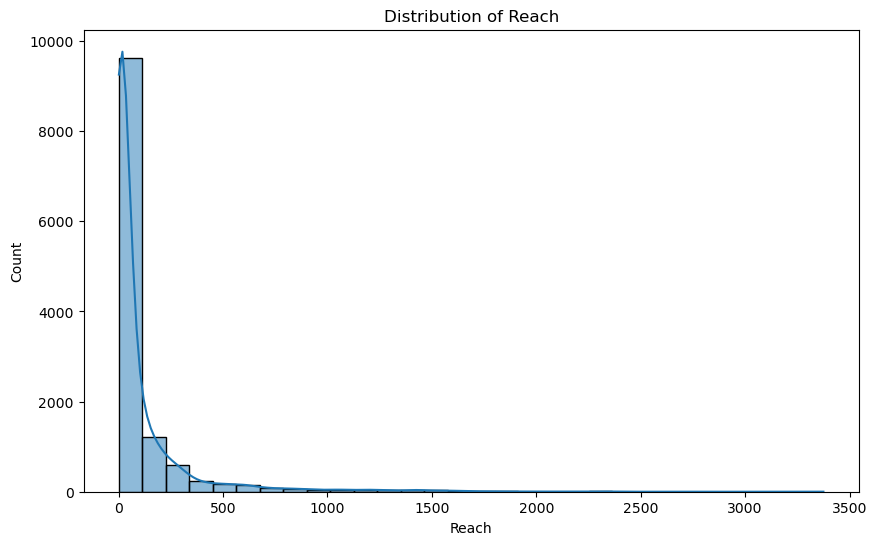

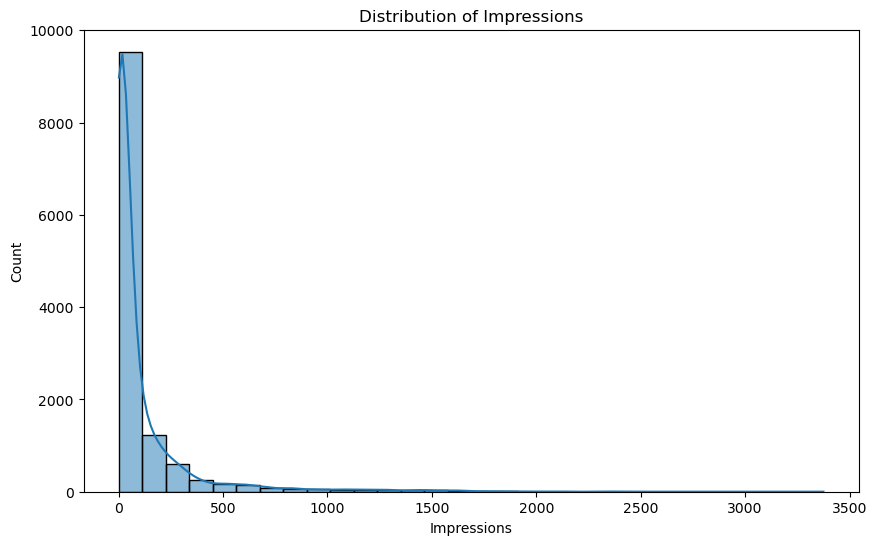

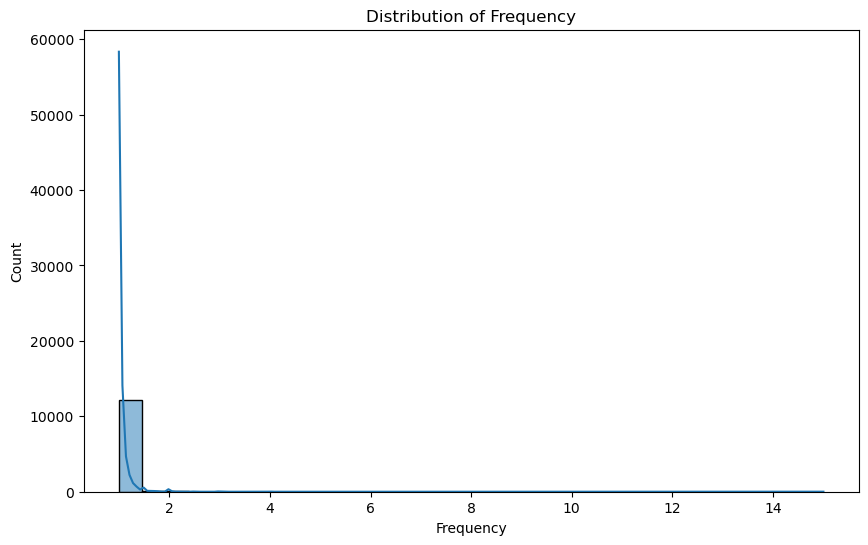

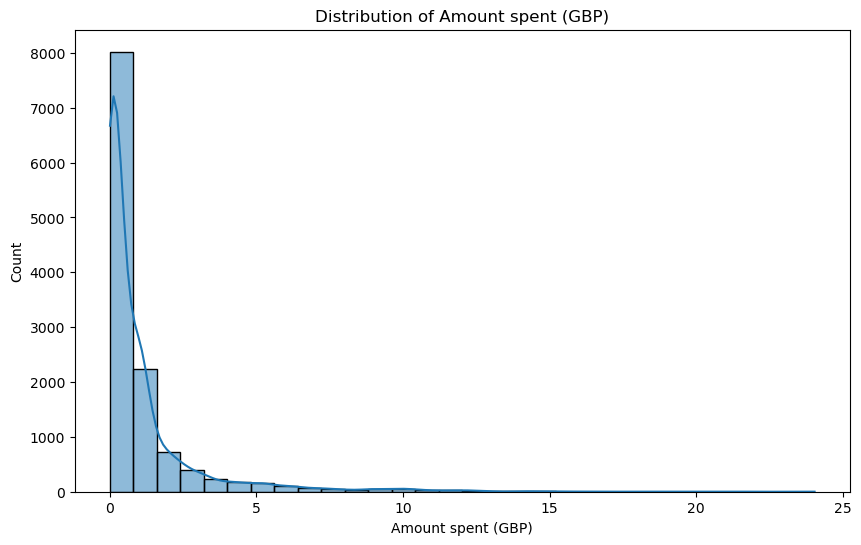

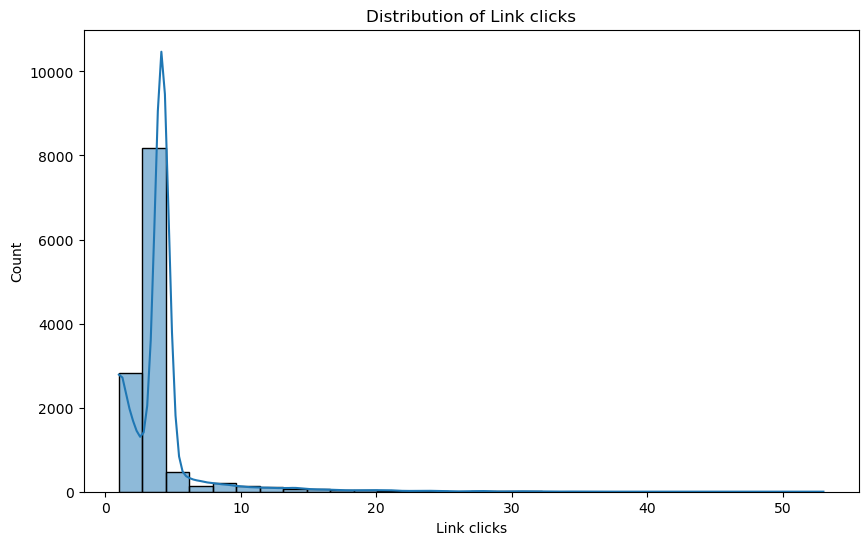

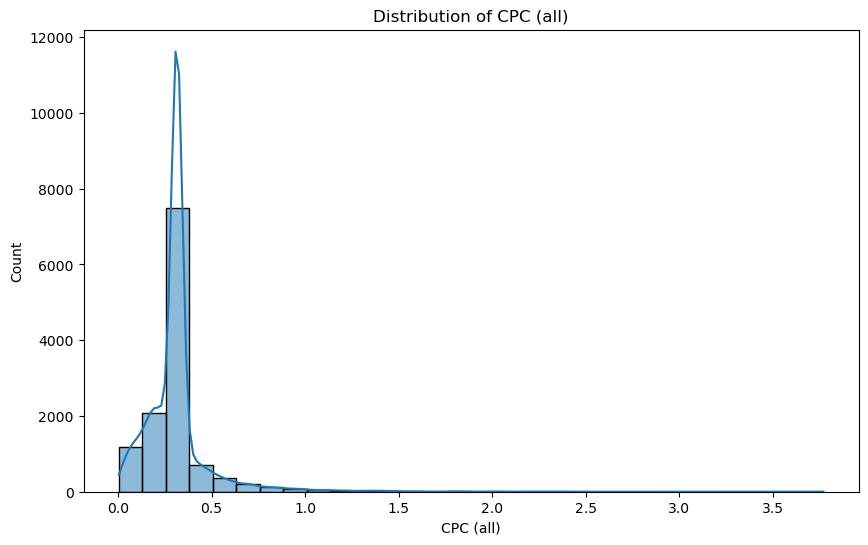

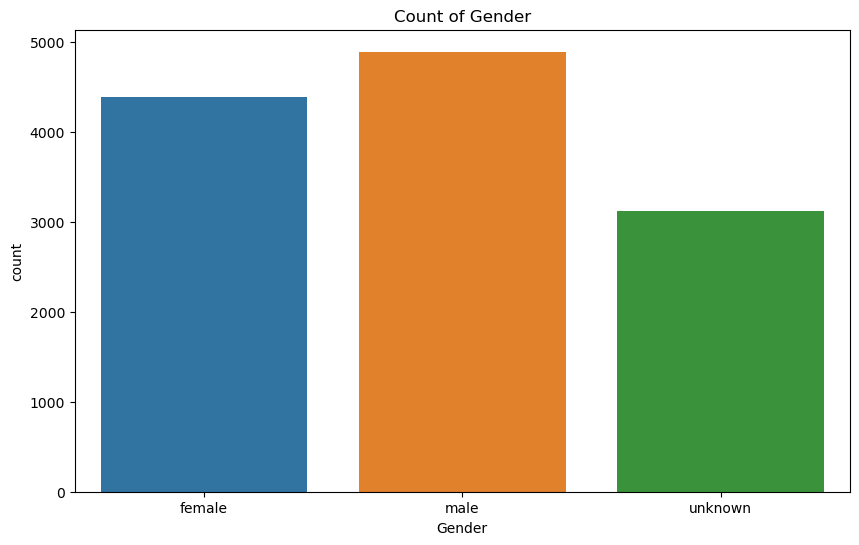

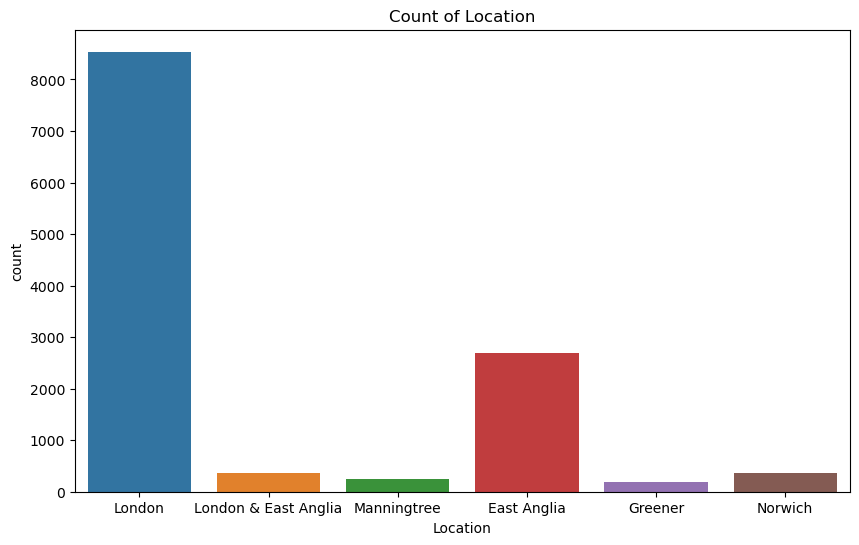

In [13]:
# Histograms for numerical columns
numerical_cols = ['Reach', 'Impressions', 'Frequency', 'Amount spent (GBP)', 'Link clicks', 'CPC (all)']

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(fb_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Count plots for categorical columns
categorical_cols = ['Gender', 'Location']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=fb_data)
    plt.title(f'Count of {col}')
    plt.show()


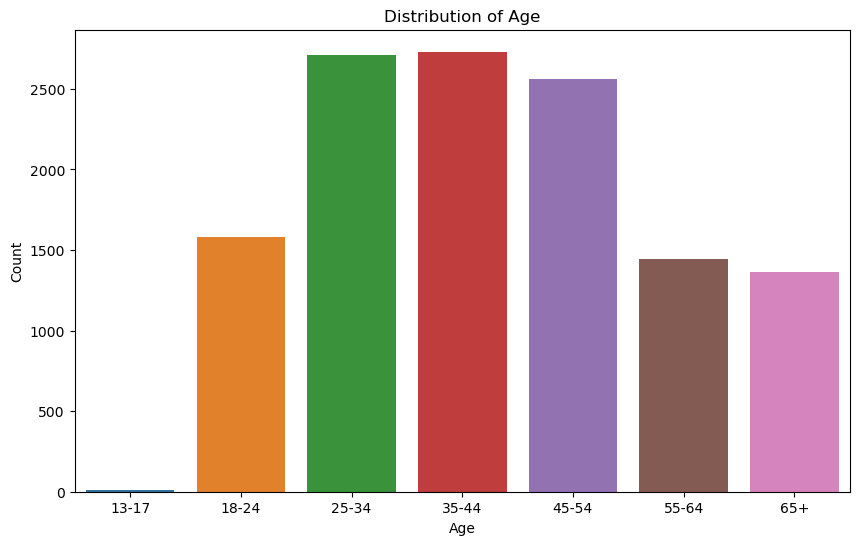

In [14]:
# Visualize the distribution of 'Age' in the reduced dataset
age_order = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='Age', data=fb_data, order= age_order)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x labels readable
plt.show()

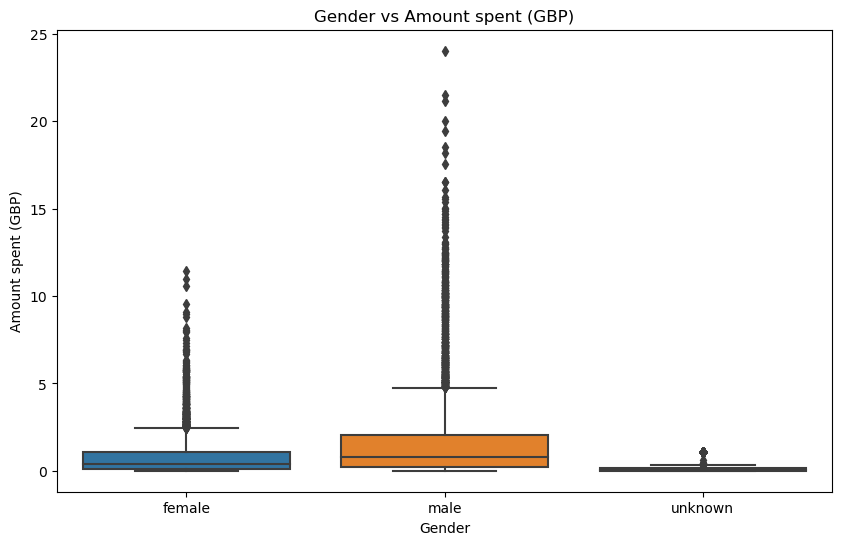

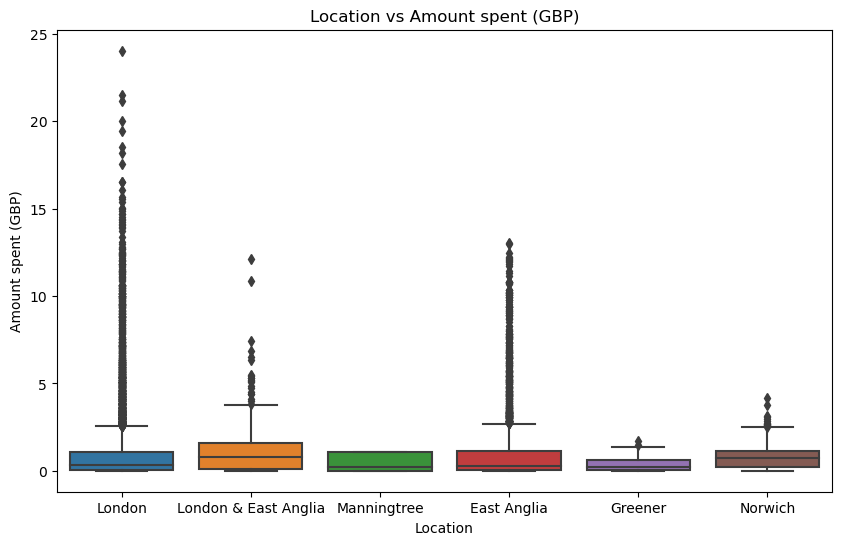

In [15]:
#Box plots for categorical columns against target
for col in categorical_cols:
 plt.figure(figsize=(10, 6))
 sns.boxplot(x=col, y='Amount spent (GBP)', data=fb_data)
 plt.title(f'{col} vs Amount spent (GBP)')
 plt.show()

### Correlation Matrix

C:\Users\Asad\AppData\Local\Temp\ipykernel_7500\2473997721.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = fb_data.corr()


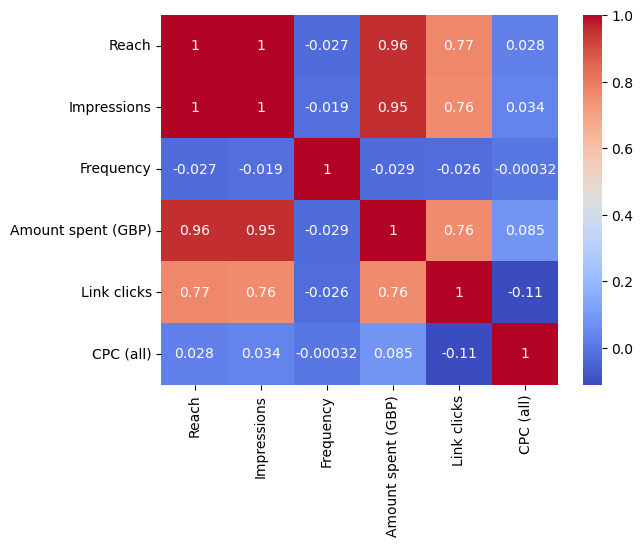

In [16]:
# Correlation matrix
correlation_matrix = fb_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## Customer Segmentation

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
features = fb_data[['Reach', 'Impressions', 'Frequency', 'Amount spent (GBP)']]

# Standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
fb_data['Cluster'] = kmeans.fit_predict(scaled_features)

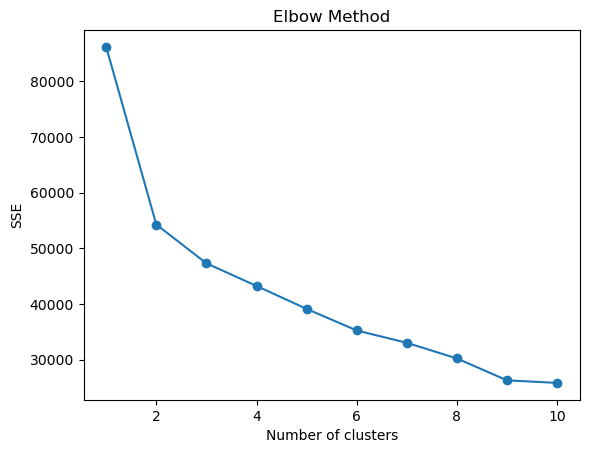

C:\Users\Asad\AppData\Local\Temp\ipykernel_7500\2866510624.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_analysis = fb_data.groupby('Cluster').mean()


               Reach  Impressions  Frequency  Amount spent (GBP)  Link clicks  \
Cluster                                                                         
0         474.874133   493.212091   1.037797            4.328846     7.724469   
1        1344.163636  1373.985455   1.022904           10.293469    20.061818   
2          44.670288    46.616534   1.050855            0.538382     3.449481   

         CPC (all)  
Cluster             
0         0.336530  
1         0.243132  
2         0.314964  
Silhouette Score: 0.4403559981272305


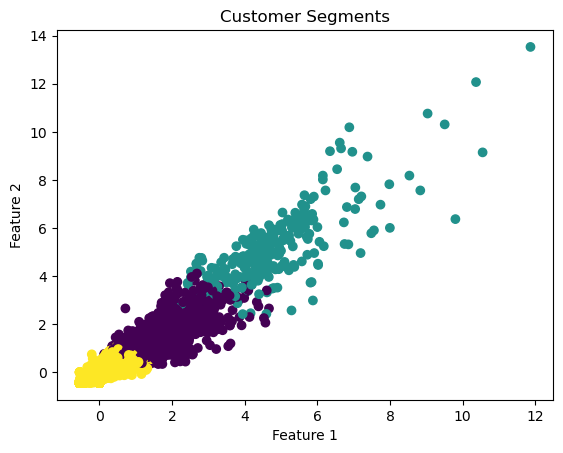

In [18]:
# Select relevant features
features = ['Age', 'Gender', 'Location', 'Amount spent (GBP)', 'Reach', 'Impressions', 'Frequency', 'Link clicks']

# Separate numerical and categorical features
numerical_features = ['Amount spent (GBP)', 'Reach', 'Impressions', 'Frequency', 'Link clicks']
categorical_features = ['Age', 'Gender', 'Location']

# Preprocessing pipelines for both numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append k-means clustering to preprocessing pipeline
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('clusterer', KMeans(n_clusters=3, random_state=42))])

# Fit the model
kmeans_pipeline.fit(fb_data[features])

# Predict the cluster for each customer
fb_data['Cluster'] = kmeans_pipeline.predict(fb_data[features])

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = Pipeline(steps=[('preprocessor', preprocessor),
                             ('clusterer', KMeans(n_clusters=k, random_state=42))])
    kmeans.fit(fb_data[features])
    sse.append(kmeans.named_steps['clusterer'].inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Apply k-means clustering with the chosen number of clusters
optimal_clusters = 3  # for example, based on the elbow plot
kmeans_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('clusterer', KMeans(n_clusters=optimal_clusters, random_state=42))])
fb_data['Cluster'] = kmeans_pipeline.fit_predict(fb_data[features])

# Analyze the clusters
cluster_analysis = fb_data.groupby('Cluster').mean()
print(cluster_analysis)

# Calculate silhouette score
X_transformed = preprocessor.fit_transform(fb_data[features])
sil_score = silhouette_score(X_transformed, fb_data['Cluster'])
print(f'Silhouette Score: {sil_score}')

# Visualize clusters (optional, depending on the number of features)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=fb_data['Cluster'], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Customer Segments')
plt.show()

In [19]:
# Grouping by cluster and calculating the mode for categorical variables
cluster_analysis = fb_data.groupby('Cluster').agg({
    'Gender': lambda x: x.mode()[0],  # Get the most frequent (mode) gender in each cluster
    'Age': lambda x: x.mode()[0],     # Get the most frequent (mode) age in each cluster
    'Location': lambda x: x.mode()[0] # Get the most frequent (mode) location in each cluster
})

print("Dominant Gender, Age, and Location in Each Cluster:")
print(cluster_analysis)

# You can also count occurrences to see the distribution within each cluster
gender_distribution = fb_data.groupby(['Cluster', 'Gender']).size().unstack()
age_distribution = fb_data.groupby(['Cluster', 'Age']).size().unstack()
location_distribution = fb_data.groupby(['Cluster', 'Location']).size().unstack()

print("\nGender Distribution by Cluster:")
print(gender_distribution)

print("\nAge Distribution by Cluster:")
print(age_distribution)

print("\nLocation Distribution by Cluster:")
print(location_distribution)


Dominant Gender, Age, and Location in Each Cluster:
         Gender    Age Location
Cluster                        
0          male  25-34   London
1          male  25-34   London
2        female  35-44   London

Gender Distribution by Cluster:
Gender   female    male  unknown
Cluster                         
0         215.0   794.0      NaN
1           4.0   271.0      NaN
2        4165.0  3827.0   3124.0

Age Distribution by Cluster:
Age      13-17   18-24   25-34   35-44   45-54   55-64     65+
Cluster                                                       
0          NaN   124.0   314.0   292.0   232.0    47.0     NaN
1          NaN     5.0   148.0   111.0    11.0     NaN     NaN
2         10.0  1454.0  2251.0  2328.0  2317.0  1395.0  1361.0

Location Distribution by Cluster:
Location  East Anglia  Greener  London  London & East Anglia  Manningtree  \
Cluster                                                                     
0               242.0      NaN   710.0                  

## Segment Profiling

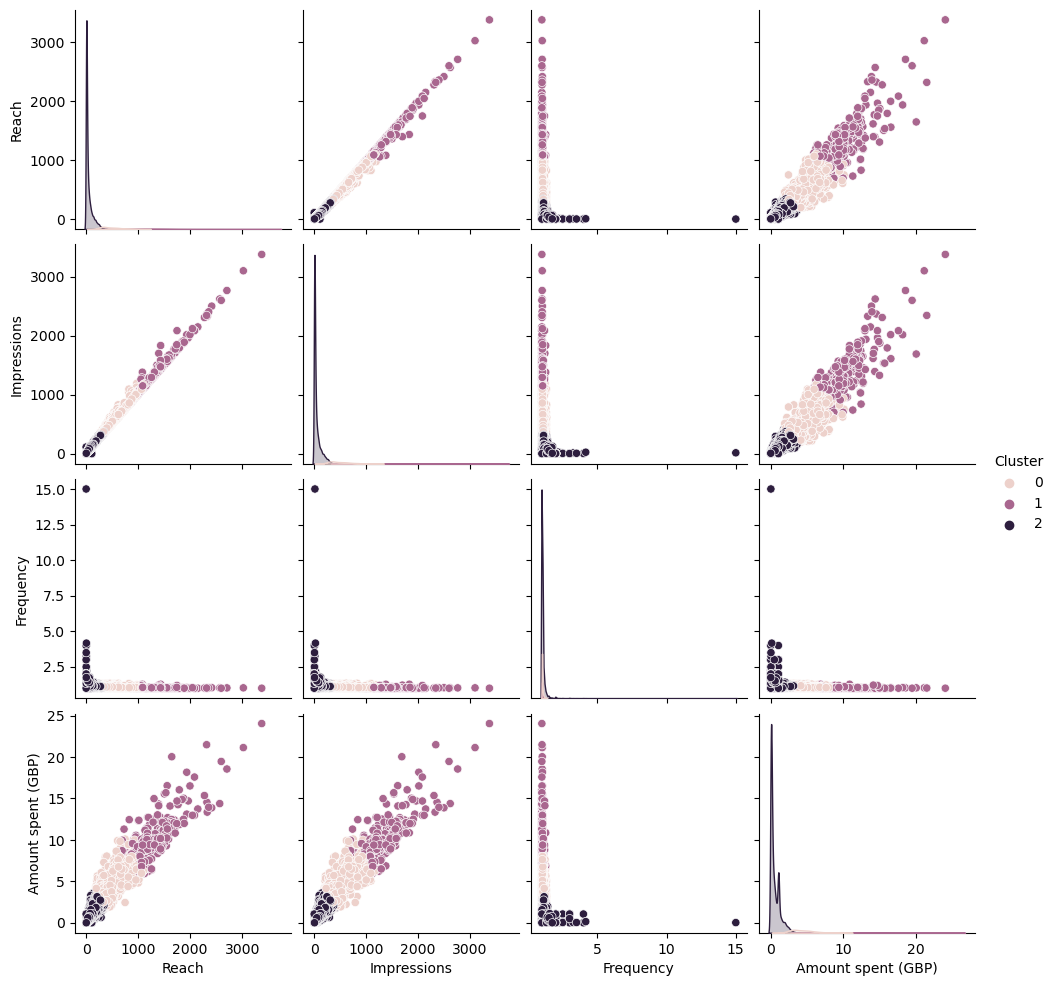

In [20]:
sns.pairplot(fb_data, hue='Cluster', vars=['Reach', 'Impressions', 'Frequency', 'Amount spent (GBP)'])
plt.show()

## Predicting cluster

In [21]:
# Define features and target variable
X = fb_data[numerical_features]
y = fb_data['Cluster']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import LabelEncoder
# Encode categorical columns
le = LabelEncoder()
def label_encode_df(df):
    df = df.copy()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = le.fit_transform(df[column])
    return df

X_train_encoded = label_encode_df(X_train)
X_test_encoded = label_encode_df(X_test)

## Data Preparation

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    print(f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Logistic Regression - Accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       302
           1       0.69      0.75      0.72        81
           2       1.00      1.00      1.00      3337

    accuracy                           0.98      3720
   macro avg       0.87      0.87      0.87      3720
weighted avg       0.98      0.98      0.98      3720

Gradient Boosting - Accuracy: 0.9946236559139785
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       302
           1       0.96      0.96      0.96        81
           2       1.00      1.00      1.00      3337

    accuracy                           0.99      3720
   macro avg       0.98      0.97      0.98      3720
weighted avg       0.99      0.99      0.99      3720



In [23]:
from sklearn.model_selection import GridSearchCV
start = timer()

rf = RandomForestClassifier(random_state=7, max_depth=40, min_samples_split=5)

# Example: Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=4, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train_encoded, y_train)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Execution time HH:MM:SS: 0:06:18.988452


In [24]:
# Best parameters and model performance
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
grid_search.best_score_
y_pred = best_model.predict(X_test_encoded)
print(f"Best Model - Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model - Accuracy: 0.9940860215053764
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       302
           1       0.95      0.98      0.96        81
           2       1.00      1.00      1.00      3337

    accuracy                           0.99      3720
   macro avg       0.97      0.98      0.97      3720
weighted avg       0.99      0.99      0.99      3720



In [25]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Create the model
model = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

# Train the model
model.fit(X_train_encoded, y_train)

# Predict
y_pred = model.predict(X_test_encoded)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[[ 276    3   23]
 [   3   78    0]
 [   0    0 3337]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       302
           1       0.96      0.96      0.96        81
           2       0.99      1.00      1.00      3337

    accuracy                           0.99      3720
   macro avg       0.98      0.96      0.97      3720
weighted avg       0.99      0.99      0.99      3720



In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y):
    
    # create a train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
    train_errors, val_errors, sizes = [], [], []
    
    # take different sizes of the training data, starting from 50s instance, with the step of 10
    for m in range(50, X_train.shape[0], 100):
        
        # fit a model
        model.fit(X_train[:m], y_train[:m])
        
        # evaluate the model on both training and validation sets
        yhat_train = model.predict(X_train[:m])
        yhat_val = model.predict(X_val)
        
        # calculate F-score and record the results
        p, r, train_fscore, s = precision_recall_fscore_support(yhat_train,
                                                                y_train[:m], average="macro")
        p, r, val_fscore, s = precision_recall_fscore_support(yhat_val, y_val, average="macro")
                
        train_errors.append(train_fscore)
        val_errors.append(val_fscore)
        sizes.append(m)
        
    # make a plot
    temp_df = pd.DataFrame({"training set size": sizes, 
                        "train": train_errors,
                        "val": val_errors})

    temp_df.plot(x="training set size", y=["train", "val"], kind="line", 
             figsize=(6, 4))

C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Asad\anaconda3\Lib\site-packages\sklearn\svm\_classes.p

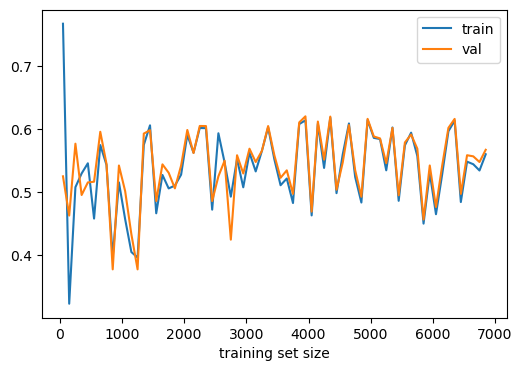

In [27]:
lsvm = LinearSVC(C=5, random_state=7, max_iter=1000)

plot_learning_curves(lsvm, X_train, y_train)